In [27]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras

In [28]:
import bayesflow as bf
from dmc import DMC

network_name = "contamination500trials"

## Create Simulator

In [29]:
simulator = DMC(
    prior_means=np.array([16., 111., 0.5, 322., 75.]), 
    prior_sds=np.array([10., 47., 0.13, 40., 23.]),
    tmax=1500,
    contamination_probability=.05
)

file_path = '../simulators/simulator_' + network_name + '.pickle'

with open(file_path, 'wb') as file:
    pickle.dump(simulator, file)

In [30]:
sims = simulator.sample(10)
for k, v in sims.items():
    print(f"Shape of {k}: {v.shape}")

Shape of A: (10, 1)
Shape of tau: (10, 1)
Shape of mu_c: (10, 1)
Shape of mu_r: (10, 1)
Shape of b: (10, 1)
Shape of rt: (10, 200, 1)
Shape of accuracy: (10, 200, 1)
Shape of conditions: (10, 200, 1)
Shape of num_obs: (10, 1)


## Create Adapter

In [31]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)

In [32]:
for k, v in adapter(sims).items():
    print(f"Shape of {k}: {v.shape}")

Shape of inference_variables: (10, 5)
Shape of summary_variables: (10, 200, 3)
Shape of inference_conditions: (10, 1)


## Create Networks and Workflow

In [33]:
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.011529)), depth=7)

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.011529)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=0.000829376961,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../checkpoints',
    checkpoint_name= network_name,
    inference_variables=["A", "tau", "mu_c", "mu_r", "b"]
)

Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)


## Generate Data and Train Offline

In [ ]:
file_path = '../data/data_offline_training/data_offline_training_' + network_name + '.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)
    
    

val_file_path = '../data/data_offline_training/data_offline_validation_' + network_name + '.pickle'

# val_data = simulator.sample(1000)

# with open(val_file_path, 'wb') as file:
#     pickle.dump(val_data, file)

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)
    

In [15]:
file_path = '../data/data_offline_training/data_offline_training_' + network_name + '.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)


In [16]:
    
val_file_path = '../data/data_offline_training/data_offline_validation_' + network_name + '.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)

In [38]:
%%time
history = workflow.fit_offline(train_data, epochs=10, batch_size=128, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 5.1040 - loss/inference_loss: 5.1040 - val_loss: 3.0218 - val_loss/inference_loss: 3.0218
Epoch 2/10
 34/391 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - loss: 3.7556 - loss/inference_loss: 3.7556

KeyboardInterrupt: 

## In Silico Validation
figs = workflow.plot_default_diagnostics(test_data=val_data)

In [39]:
approximator = keras.saving.load_model("../checkpoints/" + network_name + ".keras")

# figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))

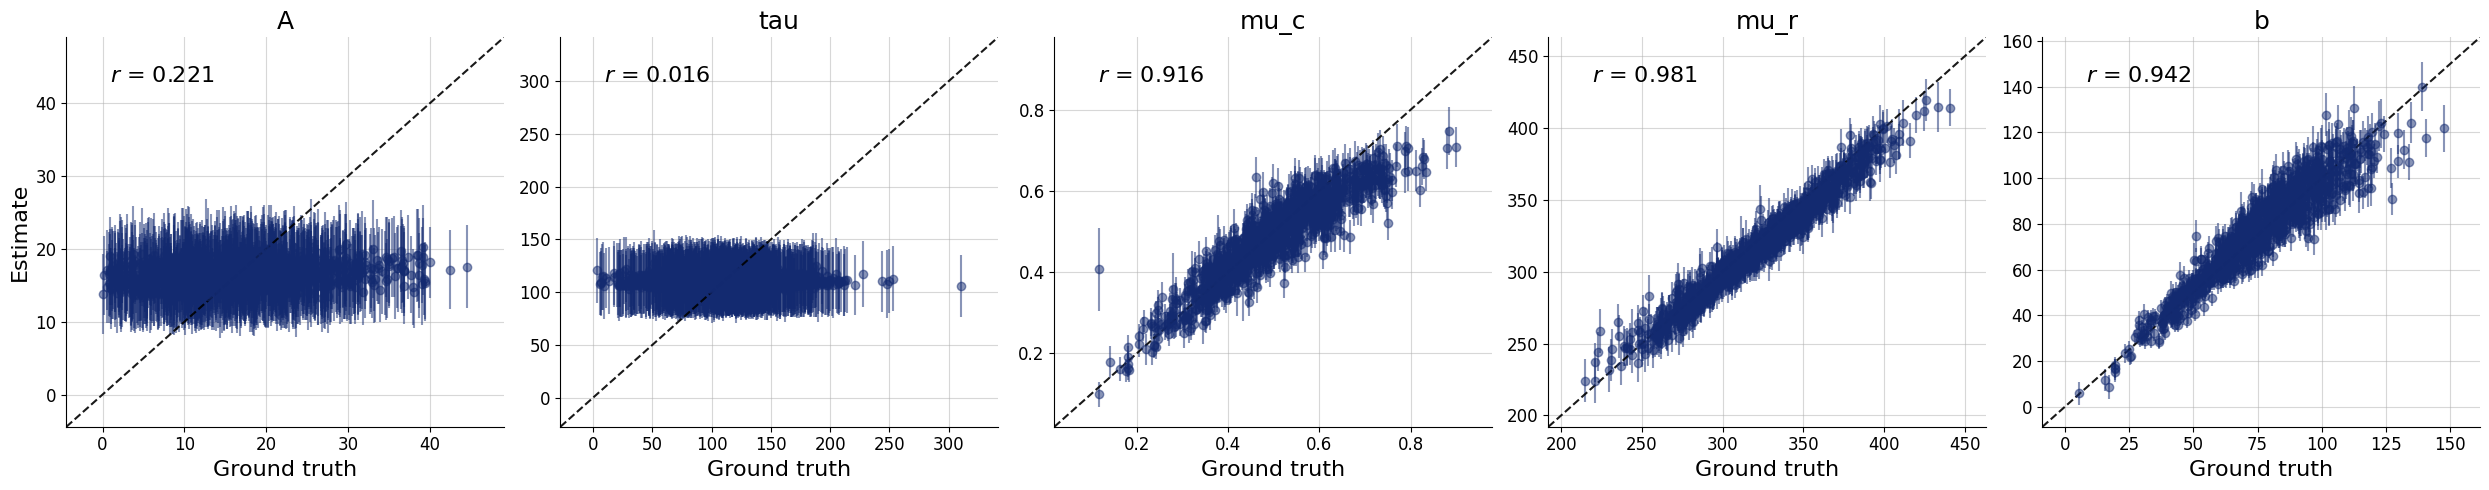

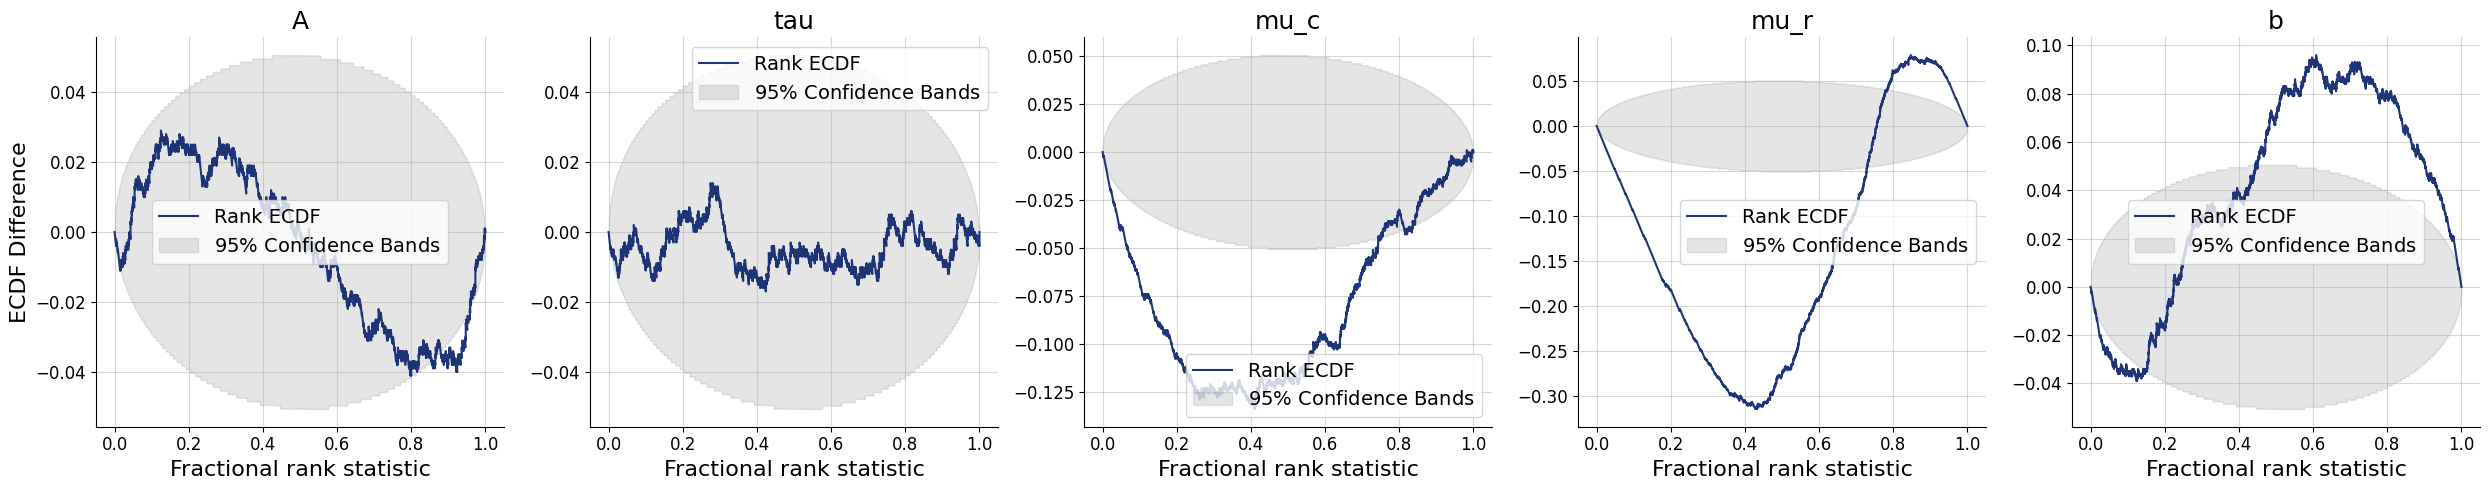

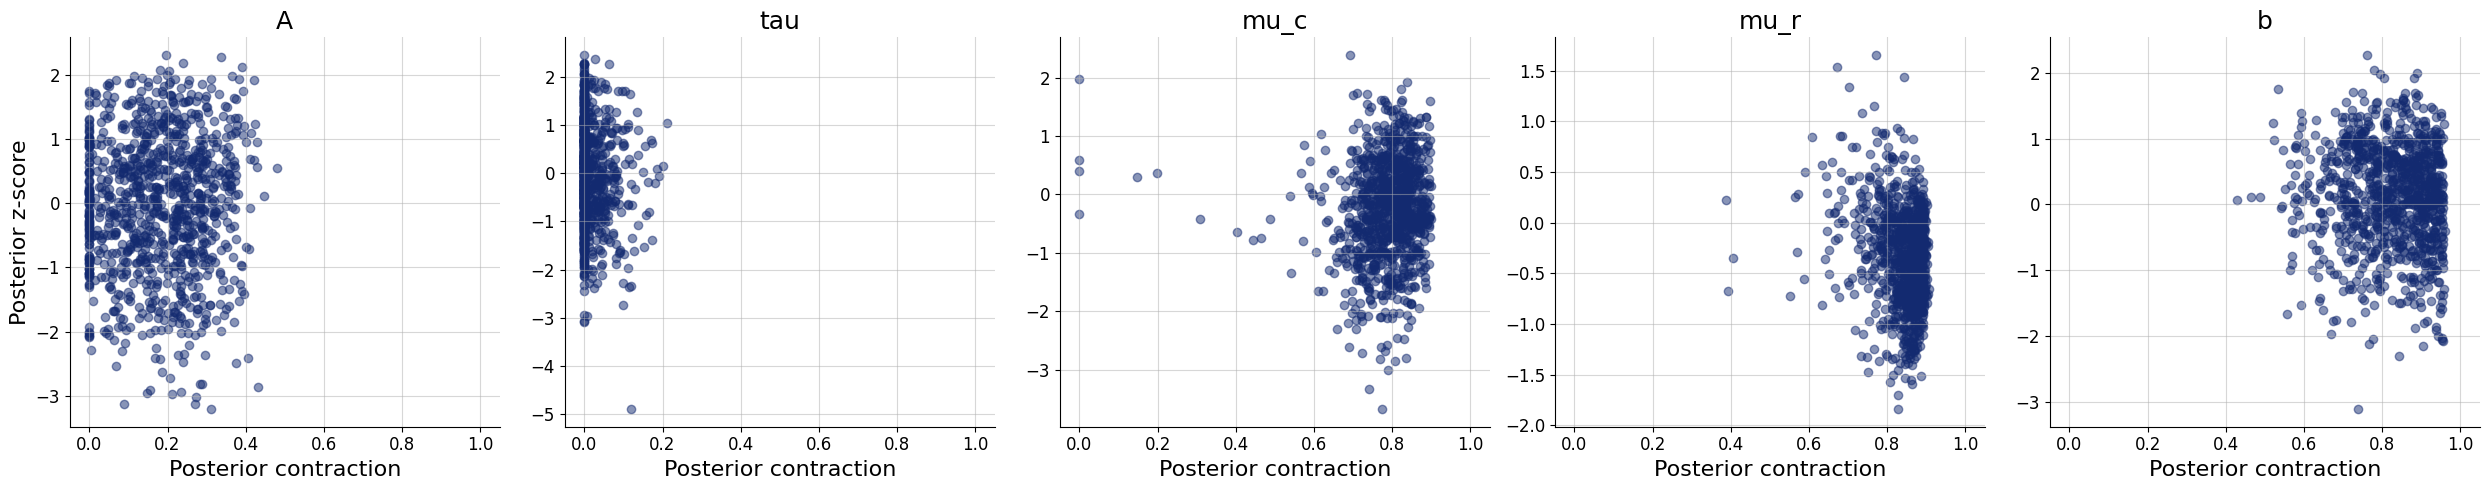

In [40]:
figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))

In [28]:
table = workflow.compute_default_diagnostics(test_data=val_data)
table

,A,tau,mu_c,t0,b
NRMSE,0.148996,0.213710,0.143126,0.052944,0.076646
Posterior Contraction,0.720386,0.491547,0.861639,0.972243,0.914590
Calibration Error,0.008816,0.042237,0.247763,0.210263,0.022632


In [ ]:
# table = workflow.compute_custom_diagnostics(test_data=val_data)

TypeError: BasicWorkflow.compute_custom_diagnostics() missing 1 required positional argument: 'metrics'

## Custom Stuff

In [28]:
samples = approximator.sample(conditions=val_data, num_samples=1000)

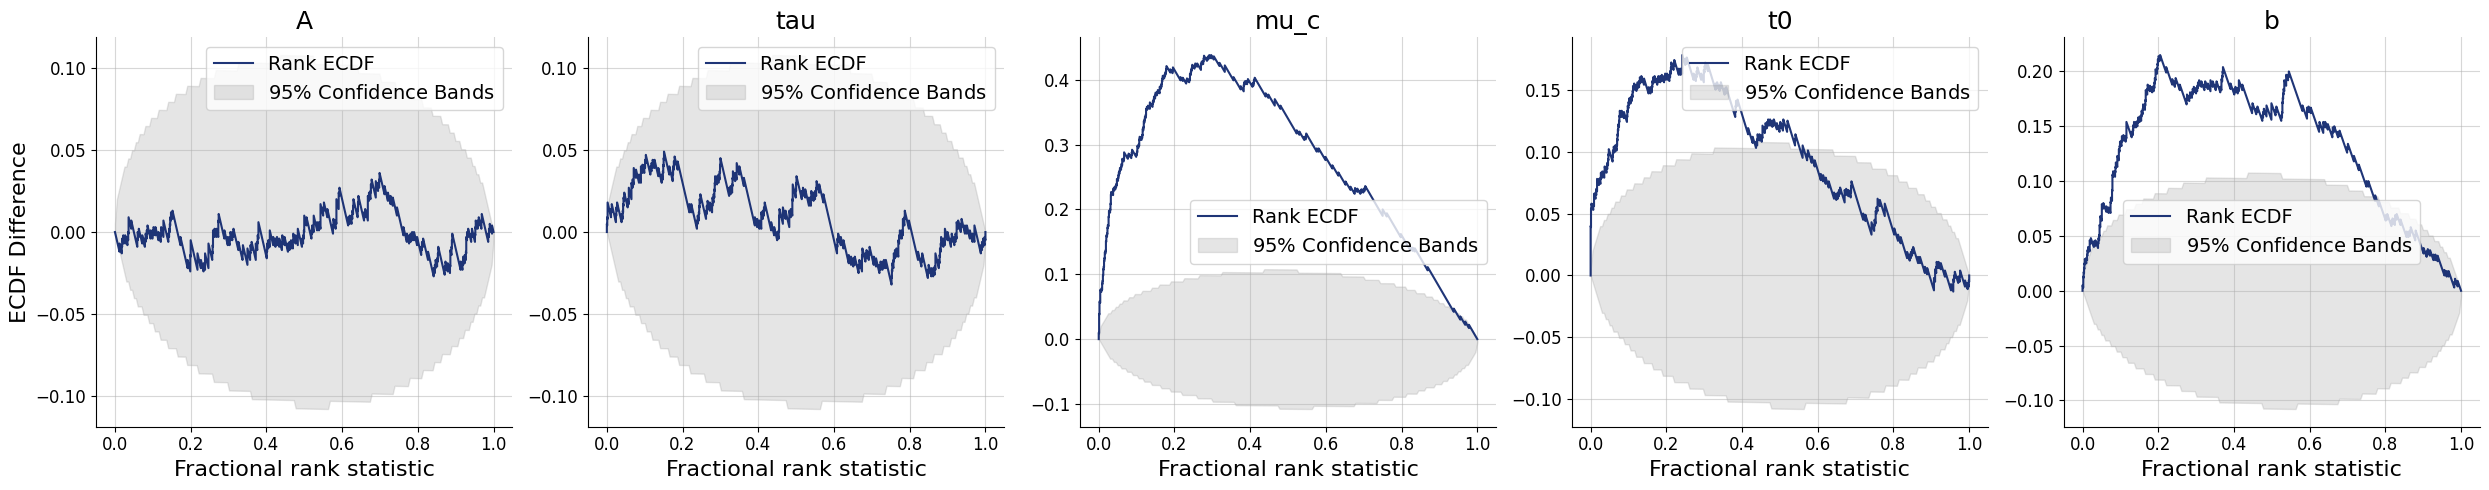

In [29]:
sbc = bf.diagnostics.plots.calibration_ecdf(samples, val_data, variable_keys=["A", "tau", "mu_c", "t0", "b"], difference=True)

## Real Data Inference

In [ ]:
#TODO



## Posterior Predictive Checks

In [ ]:
#TODO